# Visualize

In [1]:
import pandas as pd
df = pd.read_json('./topics.json', orient='records', lines=True)

In [2]:
df.head()

,news_count,name,description,category,subcategories,representative_docs,date,embedding,topic_id
0,7,Shifts in Global Investment Strategies Amid Do...,"As of May 29, 2025, financial markets are witn...",Economy,"[[""Economy/Foreign-Exchange"", ""Economy/Busines...","[LONDON, May 29 (Reuters Breakingviews) - Fore...",2025-05-29,"[-0.0353155273, -0.033418637, -0.0125434756000...",23
1,13,Ceasefire Between India and Pakistan Amid Esca...,"On May 11, 2025, a fragile ceasefire was holdi...",Society,"[[""Society/War-Conflict"", ""Politics/Foreign-Re...",[Takeaways NEW\n\nIndia and Pakistan signaled ...,2025-05-11,"[-0.0374452829, -0.0021498876000000003, -0.005...",3602
2,5,Establishment of a Special Tribunal for Russia...,"On May 9, 2025, in Lviv, Ukraine, foreign mini...",Politics,"[[""Politics/Government"", ""Politics/Foreign-Rel...",[Europe stands behind a new special tribunal f...,2025-05-09,"[-0.0384946102, -0.0293747961, -0.0159788017, ...",140
3,12,Trade Negotiations and Tariff Discussions at A...,"On May 16, 2025, during the Asia-Pacific Econo...",Economy,"[[""Economy/Economic-Union"", ""Economy/Trade""]]",[.She believes Taiwan may have agreed to reval...,2025-05-16,"[-0.0136486495, -0.0161886002, -0.0189094637, ...",2058
4,32,Ongoing Conflict and Diplomatic Efforts in Ukr...,"On May 7, 2025, French President Emmanuel Macr...",Politics,"[[""Politics/Government"", ""War-Conflict/Conflic...",[May 7 - President Volodymyr Zelenskiy said ...,2025-05-07,"[-0.0477987298, -0.0107033909, -0.0104101783, ...",140


### Project Embeddings

In [3]:
import numpy as np
from sklearn.decomposition import PCA

In [4]:
X = np.array(df['embedding'].tolist())

In [5]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

In [6]:
df['pca_embed']=X_reduced.tolist()

In [7]:
topic_embed = (
    df.groupby("topic_id")["pca_embed"]
    .apply(lambda rows: np.mean(np.stack(rows), axis=0).tolist())
)

### Topic Attention, Names

In [8]:
topic_attention = df.groupby('topic_id')['news_count'].sum()

In [9]:
idx = topic_attention.index

In [10]:
names = ['Oil Markets',
               'US Monetary Policy', 
               'Private Markets', 
               'US-China Trade Relations', 
               'Currencies',
               'Global Economic Reports',
               'Manufacturing',
               'US-Europe Diplomacy',
               'Q1 2025 Financial Results', 
               'Gaza Humanitarian Crisis',
               'Global Inflation', 
               'Musk-Trump Relations', 
               'Ukrain-Russia War',
               'Trump Tariffs',
               'Artificial Intelligence', 
               'European Financial Sector', 
               'Iran-US Nuclear Negotations', 
               'Global Agricultural Industry', 
               'India-Pakistan Conflict', 
               'Trump Tax Bill',
              ]
for i in range(len(names)):
    names[i] = f'{i}. ' + names[i]
topic_names = pd.Series(data=names, index=idx, name='name')

### Combine

In [11]:
df_plot = pd.concat([topic_embed, topic_attention, topic_names], axis=1)

In [12]:
x = np.array([x[0] for x in df_plot['pca_embed']])
y = np.array([x[1] for x in df_plot['pca_embed']])
attention = np.array(df_plot['news_count'].tolist())
names = df_plot['name']

## Create Topic Plot

In [14]:
from typing import List
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from sklearn.preprocessing import minmax_scale
from wordcloud import WordCloud
from topicwizard.plots.utils import get_default_font_path
import textwrap
import colorsys

neon_colors = [
        "rgb(255, 20, 147)",   # Deep Pink
        "rgb(0, 255, 255)",    # Cyan
        "rgb(50, 205, 50)",    # Lime Green
        "rgb(255, 69, 0)",     # Red Orange
        "rgb(148, 0, 211)",    # Dark Violet
        "rgb(255, 215, 0)",    # Gold
        "rgb(0, 191, 255)",    # Deep Sky Blue
        "rgb(255, 105, 180)",  # Hot Pink
        "rgb(127, 255, 0)",    # Chartreuse
        "rgb(255, 20, 147)",   # Deep Pink
        "rgb(0, 255, 127)",    # Spring Green
        "rgb(255, 0, 255)",    # Magenta
        "rgb(0, 255, 0)",      # Lime
        "rgb(255, 140, 0)",    # Dark Orange
        "rgb(138, 43, 226)",   # Blue Violet
        "rgb(255, 255, 0)",    # Yellow
    ]
def wrap_text_for_marker(text: str, marker_size: float, chars_per_line: int = None) -> str:
    """
    Wrap text to fit inside a marker based on marker size.
    
    Args:
        text: The text to wrap
        marker_size: The size of the marker
        chars_per_line: Maximum characters per line (auto-calculated if None)
    
    Returns:
        Text with <br> tags for line breaks
    """
    if chars_per_line is None:
        # Estimate characters per line based on marker size
        # This is a rough approximation - you may need to adjust the scaling factor
        base_chars = 8  # Base number of characters for smallest marker
        chars_per_line = max(4, int(base_chars + (marker_size - 1) * 6))
    
    # Remove HTML tags if any
    clean_text = text.replace("<b>", "").replace("</b>", "")
    
    # Wrap the text
    wrapped_lines = textwrap.wrap(clean_text, width=chars_per_line)
    
    # Join with HTML line breaks and re-add bold formatting
    wrapped_text = "<br>".join([f"<b>{line}</b>" for line in wrapped_lines])
    
    return wrapped_text

def calculate_font_size(marker_size: float, num_lines: int) -> int:
    """
    Calculate appropriate font size based on marker size and number of text lines.
    
    Args:
        marker_size: The size of the marker
        num_lines: Number of lines of text
    
    Returns:
        Font size in pixels
    """
    # Base font size calculation
    base_font_size = max(6, int(marker_size * 8))
    
    # Reduce font size if there are multiple lines
    if num_lines > 1:
        base_font_size = max(4, int(base_font_size / (1 + 0.2 * (num_lines - 1))))
    
    return min(base_font_size, 14)  # Cap at 16px

def intertopic_map(
    x: np.ndarray,
    y: np.ndarray,
    topic_importances: np.ndarray,
    topic_names: List[str],
    max_chars_per_line: int = None,
) -> go.Figure:
    """
    Create an intertopic map with text that fits inside markers.
    
    Args:
        x: X coordinates for topics
        y: Y coordinates for topics
        topic_importances: Importance scores for topics
        topic_names: Names/labels for topics
        max_chars_per_line: Maximum characters per line (auto-calculated if None)
    
    Returns:
        Plotly figure
    """
    # Scale marker sizes
    size = 30 + minmax_scale(topic_importances) * 70  # Increased scaling for better visibility
    
    # Wrap text for each marker based on its size
    wrapped_texts = []
    font_sizes = []
    
    for i, (name, marker_size) in enumerate(zip(topic_names, size)):
        wrapped_text = wrap_text_for_marker(name, marker_size, max_chars_per_line)
        wrapped_texts.append(wrapped_text)
        
        # Count lines for font size calculation
        num_lines = wrapped_text.count("<br>") + 1
        font_size = calculate_font_size(marker_size, num_lines)
        font_sizes.append(font_size)
    
    # Create the scatter plot
    topic_trace = go.Scatter(
        x=x,
        y=y,
        mode="text+markers",
        text=wrapped_texts,
        textfont=dict(size=font_sizes),  # Use calculated font sizes
        marker=dict(
            size=size,
            sizemode="area",
            sizeref=2.0 * max(size) / (100.0**2),
            sizemin=10,  # Increased minimum size to accommodate text
            color=generate_neon_colors(len(x)),
            line=dict(width=2, color="black"),
            opacity=0.8,  # Slightly transparent for better text visibility
        ),
        customdata=np.atleast_2d(np.arange(x.shape[0])).T,
        textposition="middle center",  # Center text in markers
    )
    
    fig = go.Figure([topic_trace])
    fig.update_layout(
        clickmode="event",
        modebar_remove=["lasso2d", "select2d"],
        showlegend=False,
        hovermode="closest",
        plot_bgcolor="white",
        dragmode="pan",
        margin=dict(l=20, r=20, b=20, t=20, pad=10),  # Added some margin
        font=dict(family="Arial, sans-serif"),  # Consistent font family
    )
    
    # Remove hover info since text is already visible
    fig.update_traces(hovertemplate="", hoverinfo="none")
    fig.update_coloraxes(showscale=False)
    
    # Style axes
    fig.update_xaxes(
        showticklabels=False,
        title="",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        linewidth=6,
        mirror=True,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
        showgrid=False,
    )
    fig.update_yaxes(
        showticklabels=False,
        title="",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        mirror=True,
        linewidth=6,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
        showgrid=False,
    )
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    return fig

def generate_neon_colors(n_colors: int) -> List[str]:
    """
    Generate a list of vibrant neon colors with transparency.
    
    Args:
        n_colors: Number of colors to generate
        
    Returns:
        List of RGBA color strings
    """
    neon_colors = []
    
    # Pre-defined neon colors for variety
    base_neon_hues = [
        (0.83, 1.0, 1.0),    # Neon Blue/Cyan
        (0.33, 1.0, 1.0),    # Neon Green
        (0.17, 1.0, 1.0),    # Neon Orange/Yellow
        (0.92, 1.0, 1.0),    # Neon Pink/Magenta
        (0.58, 1.0, 1.0),    # Neon Purple
        (0.08, 1.0, 1.0),    # Neon Red
        (0.50, 1.0, 1.0),    # Neon Cyan
        (0.75, 1.0, 1.0),    # Neon Violet
        (0.42, 1.0, 1.0),    # Neon Lime
        (0.0, 1.0, 1.0),     # Neon Red-Pink
        (0.25, 1.0, 1.0),    # Neon Yellow-Green
        (0.67, 1.0, 1.0),    # Neon Blue-Purple
    ]
    
    # If we need more colors than pre-defined, generate additional ones
    if n_colors > len(base_neon_hues):
        for i in range(len(base_neon_hues), n_colors):
            hue = (i / n_colors) % 1.0
            base_neon_hues.append((hue, 1.0, 1.0))
    
    # Convert HSV to RGB and create RGBA strings
    for i in range(n_colors):
        h, s, v = base_neon_hues[i % len(base_neon_hues)]
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        
        # Convert to 0-255 range and create RGBA with transparency
        r_255 = int(r * 255)
        g_255 = int(g * 255)
        b_255 = int(b * 255)
        
        # Use 0.7 alpha for nice transparency while maintaining vibrancy
        rgba_color = f"rgba({r_255}, {g_255}, {b_255}, 0.7)"
        neon_colors.append(rgba_color)
    
    return neon_colors

fig_topic_map = intertopic_map(x=x[9:],y=y[9:],topic_importances=attention[9:],topic_names=names[9:])

## Time Plot

### Prepare Data

In [15]:
all_dates = pd.date_range(df["date"].min(), df["date"].max())
# Pivot, fill missing with 0
pivoted = df.pivot_table(
    index="topic_id",
    columns="date",
    values="news_count",
    aggfunc="sum",
    fill_value=0
).reindex(columns=all_dates, fill_value=0)
# get the time series for each topic
time_series = pivoted.apply(lambda row: row.tolist(), axis=1)

In [16]:
def document_timeline(
    topic_timeline: np.ndarray, 
    topic_names: List[str], 
    # topic_colors: np.ndarray
) -> go.Figure:
    topic_timeline = topic_timeline.T
    traces = []
    n_topics = len(topic_names)
    for topic_id in range(n_topics):
        timeline = topic_timeline.iloc[topic_id]
        timeline = np.squeeze(np.asarray(timeline))
        trace = go.Scattergl(
            x=np.arange(timeline.shape[0]),
            y=timeline,
            mode="lines",
            name=topic_names.iloc[topic_id],
            # marker=dict(color=topic_colors[topic_id]),
        )
        traces.append(trace)
    fig = go.Figure(data=traces)
    fig.update_layout(
        hovermode="closest",
        plot_bgcolor="white",
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
        legend_title="Topic",
    )
    fig.update_coloraxes(showscale=False)
    fig.update_xaxes(
        title="Window",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        linewidth=6,
        mirror=True,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
    )
    fig.update_yaxes(
        title="Importance",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        mirror=True,
        linewidth=6,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
    )
    return fig

In [17]:
fig_timeline = document_timeline(time_series, topic_names)

# Creating the Webpage

## Modify Individual Plots

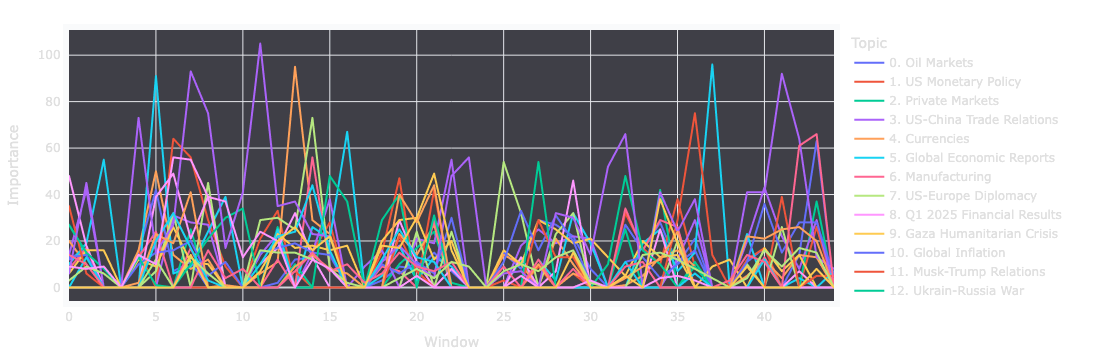

In [20]:
import dash
from dash import dcc, html, Input, Output
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from topicwizard.pipeline import make_topic_pipeline
# from topicwizard.figures import topic_map, document_topic_timeline
from topicwizard.plots.topics import wordcloud as topic_wordcloud
import topicwizard.prepare.topics as prepare



plotly_dark_template = {
    'layout': {
        'paper_bgcolor': 'rgba(0,0,0,0)',
        'plot_bgcolor': 'rgba(0,0,0,0)',
        'font': {'color': '#E0E0E0'},
        'colorway': ['#00D4FF', '#FF6B9D', '#00FF88', '#FFD700', '#FF4081', '#00BCD4', '#FF5722', '#9C27B0', '#4CAF50', '#FFC107'],
    }
}

# Add neon colors with transparency to the topic map dots
neon_colors = [
    'rgba(0, 212, 255, 0.7)',    # Neon cyan
    'rgba(255, 107, 157, 0.7)',  # Neon pink
    'rgba(0, 255, 136, 0.7)',    # Neon green
    'rgba(255, 215, 0, 0.7)',    # Neon gold
    'rgba(255, 64, 129, 0.7)',   # Neon magenta
    'rgba(0, 188, 212, 0.7)',    # Neon teal
    'rgba(255, 87, 34, 0.7)',    # Neon orange
    'rgba(156, 39, 176, 0.7)',   # Neon purple
    'rgba(76, 175, 80, 0.7)',    # Neon lime
    'rgba(255, 193, 7, 0.7)'     # Neon amber
]

# Force update colors and move labels inside dots
for i, trace in enumerate(fig_topic_map.data):
    if hasattr(trace, 'marker'):
        # Set color for individual points if it's a scatter plot
        if hasattr(trace, 'x') and len(trace.x) > 1:
            # Multiple points in this trace - assign different colors
            trace.marker.color = [neon_colors[j % len(neon_colors)] for j in range(len(trace.x))]
        else:
            # Single point or trace-level coloring
            trace.marker.color = neon_colors[i % len(neon_colors)]
          # Significantly increased to fit text labels
        
        # Make dots much bigger and add labels inside
        trace.marker.size = 80
        trace.marker.line = dict(width=2, color='rgba(255,255,255,0.8)')
        
        # Move text inside the markers
        if hasattr(trace, 'text'):
            trace.textposition = 'middle center'
            trace.textfont = dict(
                size=12,
                color='white',
                family='Arial Black'
            )
            trace.mode = 'markers+text'
        
        # If text is in hovertext, move it to text
        if hasattr(trace, 'hovertext') and not hasattr(trace, 'text'):
            trace.text = trace.hovertext
            trace.textposition = 'middle center'
            trace.textfont = dict(
                size=12,
                color='white',
                family='Arial Black'
            )
            trace.mode = 'markers+text'

# Also try updating the traces if it exists
if hasattr(fig_topic_map, 'update_traces'):
    fig_topic_map.update_traces(
        marker=dict(
            size=80 + 150*minmax_scale(attention)[9:],
            line=dict(width=2, color='rgba(255,255,255,0.8)'),
            colorscale=None  # Remove any existing colorscale
        ),
        textposition='middle center',
        textfont=dict(
            size=12,
            color='white',
            family='Arial Black'
        ),
        mode='markers+text'
    )

fig_topic_map.update_layout(
    template='plotly_dark',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(15,15,25,0.8)',
    font=dict(color='#E0E0E0', size=12),
    title=dict(font=dict(size=16, color='#00D4FF')),
    margin=dict(l=5, r=5, t=25, b=5),
    autosize=True,
    height=None,
    showlegend=False
)

# fig_timeline = document_topic_timeline(topic_data, document=corpus[0])
fig_timeline.update_layout(
    template='plotly_dark',
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(15,15,25,0.8)',
    font=dict(color='#E0E0E0', size=12),
    title=dict(font=dict(size=16, color='#00D4FF')),
    margin=dict(l=30, r=10, t=30, b=30),
    autosize=True,
    height=None
)

# Attach document indices to timeline scatter points for selection
# for trace in fig_timeline.data:
#     if hasattr(trace, 'customdata') or "text" in str(type(trace)):
#         trace.customdata = list(range(len(corpus)))

# topic_importances, term_importances, topic_term_importances = prepare.topic_importances(
#     topic_data["topic_term_matrix"],
#     topic_data["document_term_matrix"],
#     topic_data["document_topic_matrix"],
# )

## Dash App

In [46]:
import base64
app = dash.Dash(__name__)
image_path = "/Users/reda/topicwizard/examples/logo2.png"
encoded = base64.b64encode(open(image_path, "rb").read()).decode()

# Enhanced CSS styling
app.layout = html.Div([
    # Header
    html.Div([
        html.Div([
            # SVG Logo as raw HTML
            html.Div([
                html.Div([
                    dcc.Markdown('''
                    <svg viewBox="0 0 100 100" width="60" height="60" style="filter: drop-shadow(0 0 15px rgba(0,212,255,0.6));">
                        <defs>
                            <linearGradient id="gradient1" x1="0%" y1="0%" x2="100%" y2="100%">
                                <stop offset="0%" style="stop-color:#00D4FF"/>
                                <stop offset="100%" style="stop-color:#FF6B9D"/>
                            </linearGradient>
                            <linearGradient id="gradient2" x1="0%" y1="0%" x2="100%" y2="100%">
                                <stop offset="0%" style="stop-color:#00FF88"/>
                                <stop offset="100%" style="stop-color:#00D4FF"/>
                            </linearGradient>
                            <radialGradient id="gradient3">
                                <stop offset="0%" style="stop-color:#FF6B9D"/>
                                <stop offset="100%" style="stop-color:#00D4FF"/>
                            </radialGradient>
                            <radialGradient id="gradient4">
                                <stop offset="0%" style="stop-color:#FFD700"/>
                                <stop offset="100%" style="stop-color:#FF6B9D"/>
                            </radialGradient>
                        </defs>
                        <!-- Outer circle -->
                        <circle cx="50" cy="50" r="48" fill="none" stroke="url(#gradient1)" stroke-width="3"/>
                        <!-- Grid lines and connections -->
                        <line x1="2" y1="50" x2="98" y2="50" stroke="url(#gradient2)" stroke-width="2"/>
                        <line x1="50" y1="2" x2="50" y2="98" stroke="url(#gradient2)" stroke-width="2"/>
                        <line x1="14" y1="14" x2="86" y2="86" stroke="url(#gradient2)" stroke-width="2"/>
                        <line x1="86" y1="14" x2="14" y2="86" stroke="url(#gradient2)" stroke-width="2"/>
                        <line x1="26" y1="8" x2="74" y2="92" stroke="url(#gradient2)" stroke-width="1.5"/>
                        <line x1="74" y1="8" x2="26" y2="92" stroke="url(#gradient2)" stroke-width="1.5"/>
                        <line x1="8" y1="26" x2="92" y2="74" stroke="url(#gradient2)" stroke-width="1.5"/>
                        <line x1="92" y1="26" x2="8" y2="74" stroke="url(#gradient2)" stroke-width="1.5"/>
                        <line x1="18" y1="32" x2="82" y2="68" stroke="url(#gradient2)" stroke-width="1"/>
                        <line x1="82" y1="32" x2="18" y2="68" stroke="url(#gradient2)" stroke-width="1"/>
                        <line x1="32" y1="18" x2="68" y2="82" stroke="url(#gradient2)" stroke-width="1"/>
                        <line x1="68" y1="18" x2="32" y2="82" stroke="url(#gradient2)" stroke-width="1"/>
                        <!-- Nodes -->
                        <circle cx="2" cy="50" r="4" fill="url(#gradient3)"/>
                        <circle cx="98" cy="50" r="4" fill="url(#gradient3)"/>
                        <circle cx="50" cy="2" r="4" fill="url(#gradient3)"/>
                        <circle cx="50" cy="98" r="4" fill="url(#gradient3)"/>
                        <circle cx="14" cy="14" r="4" fill="url(#gradient3)"/>
                        <circle cx="86" cy="86" r="4" fill="url(#gradient3)"/>
                        <circle cx="86" cy="14" r="4" fill="url(#gradient3)"/>
                        <circle cx="14" cy="86" r="4" fill="url(#gradient3)"/>
                        <circle cx="26" cy="26" r="4" fill="url(#gradient3)"/>
                        <circle cx="74" cy="74" r="4" fill="url(#gradient3)"/>
                        <circle cx="74" cy="26" r="4" fill="url(#gradient3)"/>
                        <circle cx="26" cy="74" r="4" fill="url(#gradient3)"/>
                        <circle cx="38" cy="50" r="4" fill="url(#gradient3)"/>
                        <circle cx="62" cy="50" r="4" fill="url(#gradient3)"/>
                        <circle cx="50" cy="38" r="4" fill="url(#gradient3)"/>
                        <circle cx="50" cy="62" r="4" fill="url(#gradient3)"/>
                        <circle cx="50" cy="50" r="5" fill="url(#gradient4)"/>
                    </svg>
                    ''', dangerously_allow_html=True)
                ])
            ], style={"margin-right": "1rem"}),
            
            # Title Text
    #         html.Div([
    #            html.Img(
    #     src="data:image/png;base64," + encoded,  # URL or local asset
    #     style={"height": "50px"}  # Optional styling
    # ),
    #             html.H1("My Heading", style={"marginLeft": "10px"}),
    #             # html.H1("MSCI Event Analytics Dashboard", className="main-title"),
    #             # html.P("Interactive Topic Modeling & Document Analysis", className="subtitle")
    #         ])
            html.Div(
    [
        html.Div(
            [
                html.Img(src="data:image/png;base64," + encoded, style={"height": "100px"}),
                # html.H1("My Heading", style={"marginLeft": "10px"}),
                html.H1(" MSCI Event Analytics Dashboard", className="main-title",style={"marginLeft": "10px"}),
                # html.P("Interactive Topic Modeling & Document Analysis", className="subtitle"),
            ],
            style={"display": "flex", "alignItems": "center"}
        )
    ]
)
        ], style={"display": "flex", "align-items": "center", "justify-content": "center"})
    ], className="header-container"),

    # Main content container
    html.Div([
        # Topic Analysis Section
        html.Div([
            html.Div([
                html.H2("Topic Landscape", className="section-title"),
                html.P("Click on any topic maker for a short description", 
                      className="section-description"),
            ], className="section-header"),
            
            html.Div([
                # Topic Map (full width)
                html.Div([
                    dcc.Graph(
                        id="topic-map", 
                        figure=fig_topic_map,
                        config={
                            'displayModeBar': False,
                            'responsive': True
                        },
                        style={
                            'height': '100%', 
                            'width': '100%',
                            'flex': '1'
                        }
                    )
                ], className="chart-container topic-map-full")
            ], className="charts-row")
        ], className="section-container"),

        # Timeline & Document Section
        html.Div([
            html.Div([
                html.H2("Document Timeline & Viewer", className="section-title"),
                html.P("Explore document topics over time and read full content", 
                      className="section-description"),
            ], className="section-header"),
            
            html.Div([
                # Timeline (left side)
                html.Div([
                    html.Div([
                        html.H3("Topic Timeline", className="chart-title"),
                        html.P("Click on any point for a description of the corresponding event", 
                              className="chart-subtitle")
                    ], className="chart-header"),
                    dcc.Graph(
                        id="timeline", 
                        figure=fig_timeline,
                        config={'displayModeBar': False},
                        style={'height': '100%', 'width': '100%'}
                    )
                ], className="chart-container timeline"),

                # Document Viewer (right side)
                html.Div([
                    html.Div([
                        html.H3("📄 Document Reader", className="chart-title"),
                        html.P("Selected document content appears here", 
                              className="chart-subtitle", id="doc-subtitle")
                    ], className="chart-header"),
                    html.Div([
                        html.Pre(
                            id="doc-preview",
                            children="🎯 Click on a point in the timeline to read the full document content...",
                            className="document-preview"
                        )
                    ], className="document-container")
                ], className="chart-container document-viewer")
            ], className="charts-row-horizontal")
        ], className="section-container"),
    ], className="main-container"),

    # Footer
    html.Div([
        html.P("Powered by MSCI | Interactive Topic Modeling Dashboard", 
               className="footer-text")
    ], className="footer")
], className="app-container")

## CSS Style

In [47]:
app.index_string = '''
<!DOCTYPE html>
<html>
    <head>
        {%metas%}
        <title>{%title%}</title>
        {%favicon%}
        {%css%}
        <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;500;600;700&display=swap" rel="stylesheet">
        <style>
            * {
                margin: 0;
                padding: 0;
                box-sizing: border-box;
            }
            
            .app-container {
                background: linear-gradient(135deg, #0a0a1a 0%, #1a1a2e 50%, #16213e 100%);
                min-height: 100vh;
                font-family: 'Inter', sans-serif;
                color: #E0E0E0;
            }
            
            .header-container {
                background: linear-gradient(90deg, rgba(0,212,255,0.1) 0%, rgba(255,107,157,0.1) 100%);
                padding: 1.5rem 0;
                text-align: center;
                border-bottom: 2px solid rgba(0,212,255,0.3);
                margin-bottom: 1rem;
            }
            
            .main-title {
                font-size: 3rem;
                font-weight: 700;
                background: linear-gradient(45deg, #00D4FF, #FF6B9D, #00FF88);
                -webkit-background-clip: text;
                -webkit-text-fill-color: transparent;
                background-clip: text;
                margin-bottom: 0.5rem;
                text-shadow: 0 0 30px rgba(0,212,255,0.3);
            }
            
            .subtitle {
                font-size: 1.2rem;
                color: #B0B0B0;
                font-weight: 300;
            }
            
            .main-container {
                max-width: 1400px;
                margin: 0 auto;
                padding: 0 1rem;
            }
            
            .section-container {
                background: rgba(255,255,255,0.03);
                border-radius: 16px;
                padding: 1rem;
                margin-bottom: 1rem;
                border: 1px solid rgba(0,212,255,0.2);
                box-shadow: 0 8px 32px rgba(0,0,0,0.3);
                backdrop-filter: blur(10px);
            }
            
            .section-header {
                margin-bottom: 0.75rem;
            }
            
            .section-title {
                font-size: 1.8rem;
                font-weight: 600;
                color: #00D4FF;
                margin-bottom: 0.5rem;
                text-shadow: 0 0 20px rgba(0,212,255,0.4);
            }
            
            .section-description {
                color: #A0A0A0;
                font-size: 1rem;
                font-weight: 300;
            }
            
            .charts-row {
                display: flex;
                gap: 1.5rem;
                flex-wrap: wrap;
            }
            
            .charts-row-horizontal {
                display: flex;
                gap: 1.5rem;
                align-items: stretch;
            }
            
            .chart-container {
                background: rgba(15,15,25,0.6);
                border-radius: 12px;
                padding: 0.25rem;
                border: 1px solid rgba(0,212,255,0.1);
                transition: all 0.3s ease;
                display: flex;
                flex-direction: column;
            }
            
            .chart-container:hover {
                border-color: rgba(0,212,255,0.3);
                box-shadow: 0 4px 20px rgba(0,212,255,0.15);
            }
            
            .topic-map-full {
                flex: 1;
                min-width: 100%;
                height: 700px;
                display: flex;
                flex-direction: column;
            }
            
            .topic-map-full .dash-graph {
                flex: 1 !important;
                height: 100% !important;
            }
            
            .timeline {
                flex: 2;
                min-width: 600px;
                height: 650px;
            }
            
            .document-viewer {
                flex: 1;
                min-width: 400px;
                height: 650px;
            }
            
            .chart-header {
                margin-bottom: 0.5rem;
            }
            
            .chart-title {
                font-size: 1.3rem;
                font-weight: 600;
                color: #FF6B9D;
                margin-bottom: 0.3rem;
            }
            
            .chart-subtitle {
                color: #A0A0A0;
                font-size: 0.9rem;
                font-weight: 300;
            }
            
            .document-container {
                background: rgba(10,10,20,0.8);
                border-radius: 8px;
                border: 1px solid rgba(0,255,136,0.2);
                overflow: hidden;
            }
            
            .document-preview {
                background: transparent;
                color: #E0E0E0;
                padding: 1rem;
                margin: 0;
                font-size: 0.9rem;
                line-height: 1.6;
                white-space: pre-wrap;
                height: 550px;
                overflow-y: auto;
                border: none;
                font-family: 'Courier New', monospace;
            }
            
            .document-preview::-webkit-scrollbar {
                width: 8px;
            }
            
            .document-preview::-webkit-scrollbar-track {
                background: rgba(0,0,0,0.3);
                border-radius: 4px;
            }
            
            .document-preview::-webkit-scrollbar-thumb {
                background: linear-gradient(45deg, #00D4FF, #FF6B9D);
                border-radius: 4px;
            }
            
            .document-preview::-webkit-scrollbar-thumb:hover {
                background: linear-gradient(45deg, #0099CC, #CC5577);
            }
            
            .footer {
                background: rgba(0,0,0,0.5);
                padding: 1.5rem;
                text-align: center;
                border-top: 1px solid rgba(0,212,255,0.2);
                margin-top: 2rem;
            }
            
            .footer-text {
                color: #808080;
                font-size: 0.9rem;
                font-weight: 300;
            }
            
            /* Responsive Design */
            @media (max-width: 1200px) {
                .charts-row, .charts-row-horizontal {
                    flex-direction: column;
                }
                
                .topic-map-full, .timeline, .document-viewer {
                    min-width: 100%;
                }
            }
            
            @media (max-width: 768px) {
                .main-title {
                    font-size: 2rem;
                }
                
                .subtitle {
                    font-size: 1rem;
                }
                
                .section-container {
                    padding: 1rem;
                }
                
                .main-container {
                    padding: 0 0.5rem;
                }
            }
        </style>
    </head>
    <body>
        {%app_entry%}
        <footer>
            {%config%}
            {%scripts%}
            {%renderer%}
        </footer>
    </body>
</html>
'''


## Interactivity

In [48]:
# Show document text when clicking on timeline
@app.callback(
    [Output("doc-preview", "children"),
     Output("doc-subtitle", "children")],
    Input("timeline", "clickData")
)
def display_selected_doc(clickData):
    if clickData is None:
        return ("🎯 Click on a point in the timeline to read the full document content...", 
                "Selected document content appears here")
    
    point = clickData["points"][0]
    # date_idx = point.get("customdata", point.get("pointIndex", 0))
    date_idx = point.get("pointNumber")
    topic_idx = point.get("curveNumber")
    # Truncate very long documents for better display
    doc_text = str(date_idx) + ", " +str(topic_idx)
    if len(doc_text) > 3000:
        doc_text = doc_text[:3000] + "\n\n... [Document truncated for display] ..."
    
    return doc_text, f"Document #{date_idx} | {date_idx} characters"


# Show wordcloud when clicking on a topic in the topic map
@app.callback(
    Output("doc-subtitle", "children", allow_duplicate=True),
    Input("topic-map", "clickData"),
    prevent_initial_call=True
)
def display_topic_selection(clickData):
    if clickData is None:
        return "Selected document content appears here"

    # Extract the clicked topic index
    point = clickData["points"][0]
    topic_idx = point.get("customdata", point.get("pointIndex", 0))
    
    return f"Topic {topic_idx} selected from landscape view"

In [49]:
# ------------------------
# 7. Run app
# ------------------------
if __name__ == "__main__":
    app.run_server(debug=True, port=8050)

In [ ]:
import dash
from dash import html

app = dash.Dash(__name__)

app.layout = html.Div(
    [
        html.Div(
            [
                html.Img(src="data:image/png;base64," + encoded, style={"height": "50px"}),
                html.H1("My Heading", style={"marginLeft": "10px"}),
            ],
            style={"display": "flex", "alignItems": "center"}
        )
    ]
)

if __name__ == "__main__":
    app.run_server(debug=True)

In [ ]:
from typing import List
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from sklearn.preprocessing import minmax_scale
from wordcloud import WordCloud
from topicwizard.plots.utils import get_default_font_path

def intertopic_map(
    x: np.ndarray,
    y: np.ndarray,
    topic_importances: np.ndarray,
    topic_names: List[str],
) -> go.Figure:
    size = 1 + 3*minmax_scale(topic_importances)
    text = [f"<b>{name}</b>" for name in topic_names]
    topic_trace = go.Scatter(
        x=x,
        y=y,
        mode="text+markers",
        text=text,
        textfont=dict(size=10),
        marker=dict(
            size=size,
            sizemode="area",
            sizeref=2.0 * max(size) / (100.0**2),
            sizemin=4,
            color="rgb(168,162,158)",
            line=dict(width=3, color="black"),
        ),
        customdata=np.atleast_2d(np.arange(x.shape[0])).T,
    )
    fig = go.Figure([topic_trace])
    fig.update_layout(
        clickmode="event",
        modebar_remove=["lasso2d", "select2d"],
        showlegend=False,
        hovermode="closest",
        plot_bgcolor="white",
        dragmode="pan",
        margin=dict(l=0, r=0, b=0, t=0, pad=0),
    )
    fig.update_traces(textposition="top center", hovertemplate="", hoverinfo="none")
    fig.update_coloraxes(showscale=False)
    fig.update_xaxes(
        showticklabels=False,
        title="",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        linewidth=6,
        mirror=True,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
    )
    fig.update_yaxes(
        showticklabels=False,
        title="",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        mirror=True,
        linewidth=6,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
    )
    return fig

In [ ]:
fig = intertopic_map(x=x[5:15],y=y[5:15],topic_importances=attention[5:15],topic_names=names[5:15])

In [ ]:
fig.show()

In [ ]:
from typing import List
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image
from sklearn.preprocessing import minmax_scale
from wordcloud import WordCloud
from topicwizard.plots.utils import get_default_font_path
import textwrap

neon_colors = [
        "rgb(255, 20, 147)",   # Deep Pink
        "rgb(0, 255, 255)",    # Cyan
        "rgb(50, 205, 50)",    # Lime Green
        "rgb(255, 69, 0)",     # Red Orange
        "rgb(148, 0, 211)",    # Dark Violet
        "rgb(255, 215, 0)",    # Gold
        "rgb(0, 191, 255)",    # Deep Sky Blue
        "rgb(255, 105, 180)",  # Hot Pink
        "rgb(127, 255, 0)",    # Chartreuse
        "rgb(255, 20, 147)",   # Deep Pink
        "rgb(0, 255, 127)",    # Spring Green
        "rgb(255, 0, 255)",    # Magenta
        "rgb(0, 255, 0)",      # Lime
        "rgb(255, 140, 0)",    # Dark Orange
        "rgb(138, 43, 226)",   # Blue Violet
        "rgb(255, 255, 0)",    # Yellow
    ]
def wrap_text_for_marker(text: str, marker_size: float, chars_per_line: int = None) -> str:
    """
    Wrap text to fit inside a marker based on marker size.
    
    Args:
        text: The text to wrap
        marker_size: The size of the marker
        chars_per_line: Maximum characters per line (auto-calculated if None)
    
    Returns:
        Text with <br> tags for line breaks
    """
    if chars_per_line is None:
        # Estimate characters per line based on marker size
        # This is a rough approximation - you may need to adjust the scaling factor
        base_chars = 8  # Base number of characters for smallest marker
        chars_per_line = max(4, int(base_chars + (marker_size - 1) * 6))
    
    # Remove HTML tags if any
    clean_text = text.replace("<b>", "").replace("</b>", "")
    
    # Wrap the text
    wrapped_lines = textwrap.wrap(clean_text, width=chars_per_line)
    
    # Join with HTML line breaks and re-add bold formatting
    wrapped_text = "<br>".join([f"<b>{line}</b>" for line in wrapped_lines])
    
    return wrapped_text

def calculate_font_size(marker_size: float, num_lines: int) -> int:
    """
    Calculate appropriate font size based on marker size and number of text lines.
    
    Args:
        marker_size: The size of the marker
        num_lines: Number of lines of text
    
    Returns:
        Font size in pixels
    """
    # Base font size calculation
    base_font_size = max(6, int(marker_size * 8))
    
    # Reduce font size if there are multiple lines
    if num_lines > 1:
        base_font_size = max(4, int(base_font_size / (1 + 0.2 * (num_lines - 1))))
    
    return min(base_font_size, 14)  # Cap at 16px

def intertopic_map(
    x: np.ndarray,
    y: np.ndarray,
    topic_importances: np.ndarray,
    topic_names: List[str],
    max_chars_per_line: int = None,
) -> go.Figure:
    """
    Create an intertopic map with text that fits inside markers.
    
    Args:
        x: X coordinates for topics
        y: Y coordinates for topics
        topic_importances: Importance scores for topics
        topic_names: Names/labels for topics
        max_chars_per_line: Maximum characters per line (auto-calculated if None)
    
    Returns:
        Plotly figure
    """
    # Scale marker sizes
    size = 30 + minmax_scale(topic_importances) * 70  # Increased scaling for better visibility
    
    # Wrap text for each marker based on its size
    wrapped_texts = []
    font_sizes = []
    
    for i, (name, marker_size) in enumerate(zip(topic_names, size)):
        wrapped_text = wrap_text_for_marker(name, marker_size, max_chars_per_line)
        wrapped_texts.append(wrapped_text)
        
        # Count lines for font size calculation
        num_lines = wrapped_text.count("<br>") + 1
        font_size = calculate_font_size(marker_size, num_lines)
        font_sizes.append(font_size)
    
    # Create the scatter plot
    topic_trace = go.Scatter(
        x=x,
        y=y,
        mode="text+markers",
        text=wrapped_texts,
        textfont=dict(size=font_sizes),  # Use calculated font sizes
        marker=dict(
            size=size,
            sizemode="area",
            sizeref=2.0 * max(size) / (100.0**2),
            sizemin=10,  # Increased minimum size to accommodate text
            color=generate_neon_colors(len(x)),
            line=dict(width=2, color="black"),
            opacity=0.8,  # Slightly transparent for better text visibility
        ),
        customdata=np.atleast_2d(np.arange(x.shape[0])).T,
        textposition="middle center",  # Center text in markers
    )
    
    fig = go.Figure([topic_trace])
    fig.update_layout(
        clickmode="event",
        modebar_remove=["lasso2d", "select2d"],
        showlegend=False,
        hovermode="closest",
        plot_bgcolor="white",
        dragmode="pan",
        margin=dict(l=20, r=20, b=20, t=20, pad=10),  # Added some margin
        font=dict(family="Arial, sans-serif"),  # Consistent font family
    )
    
    # Remove hover info since text is already visible
    fig.update_traces(hovertemplate="", hoverinfo="none")
    fig.update_coloraxes(showscale=False)
    
    # Style axes
    fig.update_xaxes(
        showticklabels=False,
        title="",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        linewidth=6,
        mirror=True,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
    )
    fig.update_yaxes(
        showticklabels=False,
        title="",
        gridcolor="#e5e7eb",
        linecolor="#f9fafb",
        mirror=True,
        linewidth=6,
        zerolinewidth=2,
        zerolinecolor="#d1d5db",
    )
    
    return fig

def generate_neon_colors(n_colors: int) -> List[str]:
    """
    Generate a list of vibrant neon colors with transparency.
    
    Args:
        n_colors: Number of colors to generate
        
    Returns:
        List of RGBA color strings
    """
    neon_colors = []
    
    # Pre-defined neon colors for variety
    base_neon_hues = [
        (0.83, 1.0, 1.0),    # Neon Blue/Cyan
        (0.33, 1.0, 1.0),    # Neon Green
        (0.17, 1.0, 1.0),    # Neon Orange/Yellow
        (0.92, 1.0, 1.0),    # Neon Pink/Magenta
        (0.58, 1.0, 1.0),    # Neon Purple
        (0.08, 1.0, 1.0),    # Neon Red
        (0.50, 1.0, 1.0),    # Neon Cyan
        (0.75, 1.0, 1.0),    # Neon Violet
        (0.42, 1.0, 1.0),    # Neon Lime
        (0.0, 1.0, 1.0),     # Neon Red-Pink
        (0.25, 1.0, 1.0),    # Neon Yellow-Green
        (0.67, 1.0, 1.0),    # Neon Blue-Purple
    ]
    
    # If we need more colors than pre-defined, generate additional ones
    if n_colors > len(base_neon_hues):
        for i in range(len(base_neon_hues), n_colors):
            hue = (i / n_colors) % 1.0
            base_neon_hues.append((hue, 1.0, 1.0))
    
    # Convert HSV to RGB and create RGBA strings
    for i in range(n_colors):
        h, s, v = base_neon_hues[i % len(base_neon_hues)]
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        
        # Convert to 0-255 range and create RGBA with transparency
        r_255 = int(r * 255)
        g_255 = int(g * 255)
        b_255 = int(b * 255)
        
        # Use 0.7 alpha for nice transparency while maintaining vibrancy
        rgba_color = f"rgba({r_255}, {g_255}, {b_255}, 0.7)"
        neon_colors.append(rgba_color)
    
    return neon_colors

fig = intertopic_map(x=x[9:],y=y[9:],topic_importances=attention[9:],topic_names=names[9:])
fig.show()